# A quoi sert ce notebook ?

- pré-traitement des données textuelles ("description")
- vectorisation
- regression logistique à partir de l'unique variable "description"
- ajout de nouvelles variables binaires
- Decision Tree
- Random forest

In [1]:
#Import des librairies
import pandas as pd
import numpy as np
import unicodedata
import unidecode
import matplotlib.pyplot as plt
import nltk.stem
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from stop_words import get_stop_words

## Traitement des données

In [2]:
#Lecture des données
df = pd.read_csv("./../data/offers_with_10k_each_contracts.csv")
df.head()

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at
0,620861,Développeur(euse) Android expérimenté(e),LE POSTE\r\nNous mettons aujourd’hui en place ...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823
1,620862,Ingénieur QA Mobile,LE POSTE\r\nEn tant qu’Ingénieur Qualité Mobil...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319
2,330503,Vérificateur Documents Techniques Aéronautique...,Technicien Vérificateur Documents Techniques A...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706
3,623978,Chef de Produit Mobile,L’EQUIPE\r\nL’équipe Produit & Innovation poss...,1,17524.0,115.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-07-18 14:04:00.652073
4,391895,Ordonnanceur H/F,"Entreprise :\n\nOPTIMA IP, cabinet de recrutem...",1,NaN,117.0,20.0,"Sucy-en-Brie, France",48.770802,2.538860,2015-05-22 10:38:42.117161


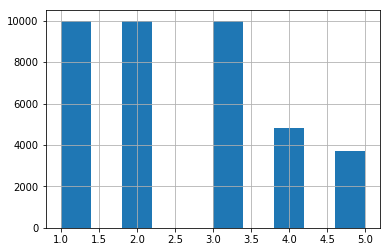

In [3]:
#Répartition des types de contrats
df.contract_id.hist()

In [4]:
#Suppression des échantillons dont la variable contrat est nulle
df = df[df.contract_id.notnull()]          #inutile mais au cas où

In [5]:
#Texte en minuscule et suppression des \n et \r
df['description'] = df['description'].str.lower()
df['title'] = df['title'].str.lower()

df.description = df.description.replace('\r', ' ', regex=True).replace('\n', ' ', regex=True).replace('\t',' ', regex=True)

In [6]:
# Dans la variable 'description'
#Remplacement des valeurs NA par ""

df['description'] = [BeautifulSoup(text, "html.parser").get_text() for text in df['description'].fillna("")]
df['title'] = [BeautifulSoup(text, "html.parser").get_text() for text in df['title'].fillna("")]

In [7]:
df.head()

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at
0,620861,développeur(euse) android expérimenté(e),le poste nous mettons aujourd’hui en place un...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823
1,620862,ingénieur qa mobile,"le poste en tant qu’ingénieur qualité mobile,...",1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319
2,330503,vérificateur documents techniques aéronautique...,technicien vérificateur documents techniques a...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706
3,623978,chef de produit mobile,l’equipe l’équipe produit & innovation possèd...,1,17524.0,115.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-07-18 14:04:00.652073
4,391895,ordonnanceur h/f,"entreprise : optima ip, cabinet de recrutemen...",1,NaN,117.0,20.0,"Sucy-en-Brie, France",48.770802,2.538860,2015-05-22 10:38:42.117161


In [8]:
#Définition du préprocessor pour supprimer les digits et transformer le texte en minuscule
def my_preprocessor(text):
    return unidecode.unidecode(''.join([letter for letter in text if not letter.isdigit()]).strip().lower())

In [9]:
#Vectorisation

#stop words fr dans stop_words
stop_words = get_stop_words('french')
stop_wordsEN = get_stop_words('english')
stop_words.extend(['ca', 'debut', 'etaient', 'etais', 'etait', 'etant', 'etat', 'ete', 'etes', 
                     'etiez', 'etions', 'etre', 'eumes', 'eutes', 'fumes', 'futes', 'meme', 
                     'nomme', 'nommee', 'nommes', 'tres'])
stop_words.extend(stop_wordsEN)

vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    analyzer="word",
    binary=False,
    max_features=3000,
    stop_words = stop_words,
preprocessor=my_preprocessor)


In [10]:
#tfidf fit de cleaned_description

vectorizer.fit(df.description)

C:\Users\Marine\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mustn', 'myse', 'needn', 'oughtn', 'shan'] not in stop_words.
  sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<function my_preprocessor at 0x000002450E0DA268>,
        smooth_idf=True,
        stop_words=['a', 'ai', 'aie', 'aient', 'aies', 'ait', 'alors', 'as', 'au', 'aucun', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aussi', 'autre', 'aux', 'avaient', 'avais', 'avait', 'avant', 'avec', 'avez', 'aviez', 'avions', 'avoir', '...ur', 'youre', 'yours', 'yourself', 'yourselves', 'youve', 'yt', 'yu', 'z', 'za', 'zero', 'zm', 'zr'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [11]:
X = pd.concat([pd.DataFrame(vectorizer.transform(df.description).todense()), 
               pd.DataFrame(vectorizer.transform(df.title).todense())], axis=1 )

In [12]:
X.shape

(38494, 6000)

## Première classification

Feature : 'description'

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Séparation du jeu de données

#X_train, X_test, y_train, y_test = train_test_split(X, df.contract_id, test_size=0.30)

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# Instance d'une régression logistique

#clf = LogisticRegression()
#clf.fit(X_train, y_train)
#clf.predict(X_test)

In [17]:
# Matrice de confusion

#print("Matrice de confusion : \n", confusion_matrix(y_test, clf.predict(X_test)))

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [19]:
# Score
#accuracy_score(clf.predict(X_test), y_test)

In [20]:
#print(classification_report(clf.predict(X_test), y_test))

Testons le **Bayes Naive**.

In [21]:
# Bayes naive

from sklearn.naive_bayes import MultinomialNB

#clf = MultinomialNB(alpha=0.1, fit_prior=True)

#clf.fit(X_train, y_train)
#print('Score = ', clf.score(X_test, y_test))

In [22]:
# Matrice de confusion

#CC = pd.crosstab(
 #   y_test,
  #  clf.predict(X_test),
   # rownames=['True'],
    #colnames=['Predicted'],
    #margins=True)
#CC

Le meilleur score que nous obtenons est 0.67 (avec la regression logistique). Pour améliorer ce score nous allons modifier, ajouter, supprimer certaines variables (feature engineering), pour ensuite tester nos données ainsi modifier sur de nouveaux algorithmes (Decision tree, Random forest, SVM...) et espérer voir le score augmenter. 

## Feature engineering

Nous ajoutons plusieurs variables qui vont jouer le rôle de "détecteur" de mot. Par exemple la nouvelle variable 'contains_cdi' vaudra 1 si le mot "cdi" est détecter dans le titre et/ou la description, 0 s'il n'est pas détecter.

In [23]:
# Avant ajout des nouvelles variables

df.head(3)

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at
0,620861,développeur(euse) android expérimenté(e),le poste nous mettons aujourd’hui en place un...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823
1,620862,ingénieur qa mobile,"le poste en tant qu’ingénieur qualité mobile,...",1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319
2,330503,vérificateur documents techniques aéronautique...,technicien vérificateur documents techniques a...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706


In [24]:
# Ajout des nouvelles variables

df['contains_cdi'] = df[['description', 'title']].apply(lambda x: 'cdi' in " ".join(x), axis=1).astype(int)
df['contains_cdd'] = df[['description', 'title']].apply(lambda x: 'cdd' in " ".join(x), axis=1).astype(int)
df['contains_stage'] = df[['description', 'title']].apply(lambda x: 'stage' in " ".join(x), axis=1).astype(int)
df['contains_alternance'] = df[['description', 'title']].apply(lambda x: 'alternance' in " ".join(x), axis=1).astype(int)
df['contains_apprenti'] = df[['description', 'title']].apply(lambda x: 'apprenti' in " ".join(x), axis=1).astype(int)
df['contains_vie'] = df[['description', 'title']].apply(lambda x: 'vie' in " ".join(x), axis=1).astype(int)

In [25]:
df.contains_cdi.value_counts()

0    33377
1     5117
Name: contains_cdi, dtype: int64

Sur environ 40 000 offres, on détecte 5 000 offres contenant 'cdi' dans le titre et/ou la description. Cela nous permet de juger que notre nouvelle variable est pertinente. 

In [26]:
df

,offer_id,title,description,contract_id,recruiter_id,department_id,industry_id,location,latitude,longitude,created_at,contains_cdi,contains_cdd,contains_stage,contains_alternance,contains_apprenti,contains_vie
0,620861,développeur(euse) android expérimenté(e),le poste nous mettons aujourd’hui en place un...,1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:37:48.322823,0,0,0,0,0,0
1,620862,ingénieur qa mobile,"le poste en tant qu’ingénieur qualité mobile,...",1,17524.0,114.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-06-01 10:45:00.950319,0,0,0,0,0,0
2,330503,vérificateur documents techniques aéronautique...,technicien vérificateur documents techniques a...,1,NaN,108.0,15.0,Donauwörth,48.735699,10.791800,2015-03-26 04:16:35.620706,0,0,0,0,0,0
3,623978,chef de produit mobile,l’equipe l’équipe produit & innovation possèd...,1,17524.0,115.0,17.0,"5 Rue François 1er, Paris, France",48.865561,2.308744,2017-07-18 14:04:00.652073,0,0,0,0,0,0
4,391895,ordonnanceur h/f,"entreprise : optima ip, cabinet de recrutemen...",1,NaN,117.0,20.0,"Sucy-en-Brie, France",48.770802,2.538860,2015-05-22 10:38:42.117161,0,0,0,0,0,0
5,626090,consultant stratégie digitale,vous êtes jeune diplômé(e) d’une grande école ...,1,17549.0,119.0,9.0,"Paris, France",48.856614,2.352222,2017-08-28 08:01:28.911562,0,0,0,0,1,0
6,612987,ingénieur études et développement c# h/f,dans le cadre des projets de développement de ...,1,17561.0,101.0,15.0,"Grenoble, France",45.188529,5.724524,2017-01-10 13:37:17.537197,0,0,0,0,0,0
7,358977,responsable bureau d'études câblage electrique...,entreprise :novajob se veut être le précurseur...,1,NaN,117.0,9.0,"LANGUEDOC ROUSSILL, France",43.593406,3.227784,2015-04-16 08:26:52.143544,0,0,0,0,0,0
8,694642,responsable ingénierie qos,"en 2017, bouygues telecom connait une très for...",1,16826.0,107.0,24.0,13 AVENUE DU MARECHAL JUIN 92360 MEUDON,48.786771,2.220587,2018-08-23 09:38:51.919709,0,0,0,0,0,0
9,565156,sales representative,,1,12374.0,103.0,9.0,"1343 East Gun Hill Road, Bronx, NY, United States",40.870953,-73.846569,2016-04-07 13:04:23.503985,0,0,0,0,0,0


In [28]:
#print(df.iloc[30017])

In [29]:
# Distinction des variables textuelles et numeriques 

text_feature = X
numeric_features = df[['contains_cdi', 'contains_cdd', 'contains_stage', 
                      'contains_alternance', 'contains_apprenti', 'contains_vie', 
                       'latitude', 'longitude', 'industry_id', 'department_id']].fillna(-1)

In [30]:
numeric_features.shape, X.shape

((38494, 10), (38494, 6000))

In [31]:
# Concatenation de toutes les variables

X_final = pd.concat([numeric_features, text_feature], axis=1 )

In [32]:
X_final.shape

(38494, 6010)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_final, df.contract_id, test_size=0.30)

In [34]:
# Regression logistique à partir des nouvelles variables

#clf = LogisticRegression()
#clf.fit(X_train, y_train)
#clf.predict(X_test)

In [35]:
#print("Matrice de confusion : \n", confusion_matrix(y_test, clf.predict(X_test)))

In [36]:
#accuracy_score(clf.predict(X_test), y_test)

In [37]:
#print(classification_report(clf.predict(X_test), y_test))

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
# Arbre de decision

#clf = DecisionTreeClassifier()
#clf.fit(X_train, y_train)
#clf.predict(X_test)

In [40]:
#print(classification_report(clf.predict(X_test), y_test))

In [41]:
#print("Matrice de confusion : \n", confusion_matrix(y_test, clf.predict(X_test)))

In [42]:
#accuracy_score(clf.predict(X_test), y_test)

In [43]:
#df["prediction"] = clf.predict(X_final)

In [44]:
#df[df.prediction!=df.contract_id][["title", "description", "prediction", "contract_id"]].head()

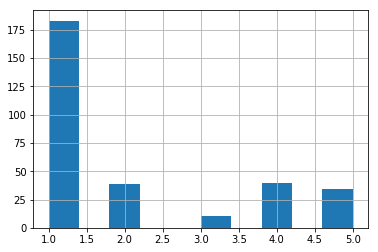

In [45]:
# Histogramme du type des offres contenant 'cdi'

df[df.title.str.contains("cdi") ].contract_id.hist()

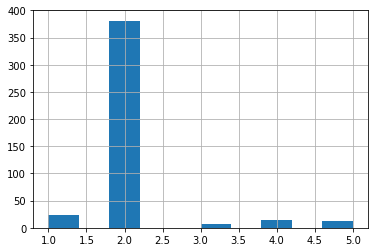

In [46]:
# Histogramme du type des offres contenant 'cdd'

df[df.title.str.contains("cdd") ].contract_id.hist()

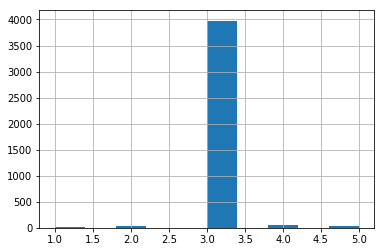

In [47]:
# Histogramme du type des offres contenant 'stage'

df[df.title.str.contains("stage") ].contract_id.hist()

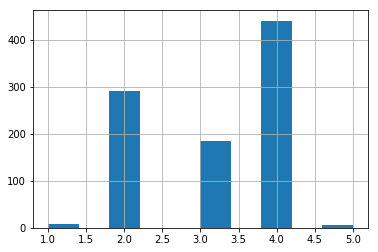

In [48]:
# Histogramme du type des offres contenant 'alternance'

df[df.title.str.contains("alternance") ].contract_id.hist()

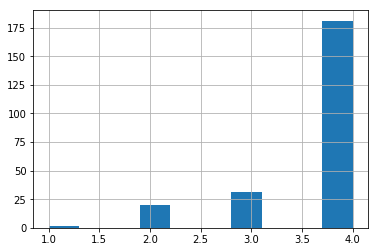

In [49]:
# Histogramme du type des offres contenant 'apprenti'

df[df.title.str.contains("apprenti") ].contract_id.hist()

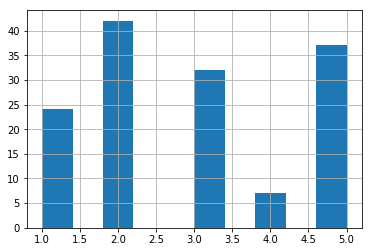

In [50]:
# Histogramme du type des offres contenant 'vie'

df[df.title.str.contains("vie") ].contract_id.hist()

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
# Random Forest

#clf =  RandomForestClassifier(#max_depth=10,
 #   n_estimators=100)
    #, max_features=6)
#clf.fit(X_train, y_train)
#clf.predict(X_test)

In [53]:
#print(classification_report(clf.predict(X_test), y_test))

In [54]:
#accuracy_score(clf.predict(X_test), y_test)

In [55]:
# Matrice de confusion

#CC = pd.crosstab(
 #   y_test,
  #  clf.predict(X_test),
   # rownames=['True'],
    #colnames=['Predicted'],
    #margins=True)
#CC

In [56]:
#plt.hist(clf.feature_importances_, bins=100)

In [57]:
# Random forest avec paramètres differents

#clf =  RandomForestClassifier(n_estimators=100, criterion='entropy', max_features= 100, bootstrap=True, oob_score=True)
#clf.fit(X_train, y_train)
#clf.predict(X_test)

In [58]:
#print(1-clf.oob_score_)

In [59]:
#clf.score(X_test,y_test)

In [60]:
#print(classification_report(clf.predict(X_test), y_test))

In [61]:
#X_train_dupli = X_train.loc[:,~X_train.columns.duplicated()]
#X_train_dupli

In [62]:
#duplicate_columns = X_train.columns[X_train.columns.duplicated()]
#duplicate_columns

In [63]:
#import xgboost as xgb
#from xgboost import XGBClassifier

#clf = xgb.XGBClassifier()
#clf.fit(X_train, y_train)
#clf.predict(X_test)

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
# Cross-validation pour trouver paramètres optimaux

#param = [{"max_features":list(range(4,64,4))}]
#digit_rf = GridSearchCV(RandomForestClassifier(n_estimators=100),param,cv=5,n_jobs=-1)
#digit_rf = digit_rf.fit(X_train, y_train)

#RandomizedSearchCV(.....)

In [66]:
1+1

2

In [67]:
from sklearn.svm import SVC

In [ ]:
# SVM
 
clf = SVC(kernel='linear', C=1, gamma=1)
#clf = SVC(C=1.0, kernel='rbf', gamma=1.5)
clf.fit(X_train, y_train)  
clf.predict(X_test)




In [ ]:
print(classification_report(clf.predict(X_test), y_test))

**BIG PROBLEME**

Certaines données sont à l'origine (manuellement) mal classées. Ce qui implique que peu importe l'algorithme utilisé, le score de prédiction ne décolle pas (=<0.70). Mais pire encore, le score ne veut rien dire ! 
 
Solution : on "biaise" les données. C'est-à-dire qu'on filtre les données : on supprime les données originellement mal classées qui contiennent dans leur titre ou leur description le (vrai) type du contrat.

Exemple : l'offre 6547 contient dans son titre le mot "stage" mais est classé parmi les cdi --> poubelle.

Regardons d'abord les offres potentiellement mal classées à l'origine.

In [ ]:
# Affichage de toutes les offres contenant dans leur titre "stage" 
# MAIS dont le contrat n'est pas classé dans stage

df[(df.title.str.contains("stage")) & (df.contract_id!=3)]

#df[(df.contains_stage == 1) & (df.contract_id!=3)]

In [ ]:
#df.description.iloc[265]

In [ ]:
# Affichage de toutes les offres contenant dans leur titre "alternance" 
# MAIS dont le contrat n'est pas classé dans alternance

df[(df.title.str.contains("alternance")) & (df.contract_id!=4)]

In [ ]:
# Affichage de toutes les offres contenant "vie" 
# MAIS dont le contrat n'est pas classé dans vie

df[(df.title.str.contains("vie")) & (df.contract_id==5)]

In [ ]:
df.description.iloc[34818]

Plusieurs conclusions sont à tirer de ses observations. 

Tout d'abord, lorsqu'on regarde rapidement les offres qui contiennent le mot "stage" dans leur description ou leur titre mais qui ne sont pas classées à l'origine (sans apprentissage) comme des stages, on s'apperçoit que ce sont effectivement des erreurs (certainement liées à l'humain qui a classifié manuellement les offres). Ceci est également le cas pour les contrats d'alternance à l'exception que certaines offres peuvent être à la fois des stage et des contrats d'alternance.

En revanche, en ce qui concerne les contrats VIE, tout va plutôt bien.

In [ ]:
# Mini filtrage des offres mal classées (à partir du titre des offres uniquement)

# df.drop(df.index[(df.title.str.contains("stage")) & (df.contract_id!=3)], axis=0)
# df.drop(df.index[(df.title.str.contains("alternance")) & (df.title.str.contains("stage")) & (df.contract_id!=4) & (df.contract_id!=3)], axis=0)

In [ ]:
#df[(df.title.str.contains("vie")) & (df.contract_id==5)]

In [ ]:
#df.description.iloc[34818]

In [ ]:
#df.title.iloc[34818]

In [ ]:
X_final.shape

In [ ]:
columns = X_final.columns[0:10].tolist() + ["description_" + elt for elt in vectorizer.get_feature_names()] + vectorizer.get_feature_names()

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
len(columns)

In [ ]:
len(clf.feature_importances_)

In [ ]:
pd.DataFrame.from_dict({"column":columns, "ponderation":clf.feature_importances_.tolist()}).sort_values("ponderation", ascending=False).head(20)

In [ ]:
X_final.columns = columns

In [ ]:
X_final.head()

In [ ]:
columns

In [ ]:
clf.feature_importances_